## 0 - Load the data

First, we will download the data, and parse the data according to the dataset description and some added features (like lengths and price format)

In [24]:
import gzip
import json
import re
import pandas as pd

def parse_jsonl_to_df(path_to_gzip):
    
    # Regex pattern that matches either an empty string OR something like "$19.95" (with 2 decimal places optional).
    price_pattern = re.compile(r'^\$?\d{1,3}(,\d{3})*(\.\d{2})?\$?$')

    records = []

    with gzip.open(path_to_gzip, 'rb') as f:
        for line in f:
            product = json.loads(line)

            # Prepare a dictionary that will become one row in our DataFrame
            row = {}

            # Direct fields (as is):
            row['also_buy']   = product.get('also_buy', [])
            row['also_view']  = product.get('also_view', [])
            row['asin']       = product.get('asin', '')
            row['brand']      = product.get('brand', '')
            row['description_list'] = product.get('description', [])
            row['feature_list']    = product.get('feature', [])
            row['price']      = product.get('price', '')
            row['title']      = product.get('title', '')
            row['main_cat']   = product.get('main_cat', '')


            ### Derived fields - NON TEXT
            # Number of also buy and also view products lists.
            row['num_also_buy'] = len(row['also_buy'])
            row['num_also_view'] = len(row['also_view'])

            # Number of images in the image list
            row['num_images'] = len(product.get('image', []))  # we do NOT keep 'image' itself, just the length

            # price_format -> check if matches a price format, like "$19.95" (valid format)
            row['price_format'] = bool(price_pattern.match(row['price'].strip()))


            ### Derived fields - TEXT
            # Number of elements in the features list
            row['num_features'] = len(row['feature_list'])

            # Description
            row['description'] = ('\n'.join(row['description_list'])).strip()

            # Features
            row['features'] = ('\n'.join(row['feature_list'])).strip()

            # We skip 'category' since it’s not used as a feature
            records.append(row)

    df = pd.DataFrame(records)
    return df

In [64]:
path = 'amz_products_small.jsonl.gz'

df = parse_jsonl_to_df(path)

# WE WILL ALSO ENSURE THERE ARE NO DUPLICATED PRODUCTS
df.drop_duplicates(subset="asin", inplace=True)

In [66]:
df.head(4)

,also_buy,also_view,asin,brand,description_list,feature_list,price,title,main_cat,num_also_buy,num_also_view,num_images,price_format,num_description,num_features,description,len_description,features,len_features
0,[],[],B00ADZ3WUM,NSI,[Bumpersticker: A day without sunshine is like...,[Official Licensed Die-Cut Sticker Designed by...,$4.68,"NSI - A Day Without Sunshine is Like, Well, Ni...",Automotive,0,0,0,True,1,5,"Bumpersticker: A day without sunshine is like,...",88,Official Licensed Die-Cut Sticker Designed by ...,450
1,[],[],B005VII5IU,General Motors,[This is the official Genuine General Motors P...,[This is the official Genuine General Motors P...,$213.16,Genuine GM Parts 10341533 Rear Bumper Valance ...,Automotive,0,0,0,True,1,1,This is the official Genuine General Motors Pa...,84,This is the official Genuine General Motors Pa...,84
2,[],[],B001QTEKVO,JLM,[HID Xenon lights are designed to be at least ...,"[Will run for approx 2500 hours, Produces 2 to...",,JLM HID Conversion Kit H13 (9008) Dual Tube B...,Automotive,0,0,1,False,1,3,HID Xenon lights are designed to be at least 3...,693,Will run for approx 2500 hours\nProduces 2 to ...,111
3,[],"[B007KLMLRM, B007KLMNNE, B0085FOJ90, B0085FOAW...",B00HWI43Q0,Spec-D Tuning,[Brand new in original packaging. Exactly the ...,[Features 1 pair of Red & Smoked lens Tail Lig...,$8.63,Spec-D Tuning LT-E362RG-F2-APC New 3D Light Ba...,Automotive,0,18,1,True,1,4,Brand new in original packaging. Exactly the s...,464,Features 1 pair of Red & Smoked lens Tail Ligh...,249


## 1 - Feature Selection (NON TEXT)

### 1.1 - Price

For selecting the price, we will take a look at how many values have a correct price format.

In [67]:
df.price_format.value_counts(normalize=True)

,proportion
price_format,
True,0.524101
False,0.475899


We see that, around half of the prices come in correct format and the other half have incorrect format.

We **WON'T be using this variable** although it could be very usefull, but around half of the records for infernece won't have a value, meaning we would have to act on it.

If we decided to act on it, we could, among others:
- Imputing it. This should be carefully done specially in this case that almos half of the records are missing
- Converting to a `has_price` boolean variable, indicating the presence or absence of the price value.

For this case, we won't use it and focus on the rest of variables.

### 1.2 - Brand

In [68]:
df.brand.value_counts(normalize=True).head(10)

,proportion
brand,
,0.029971
Generic,0.005227
uxcell,0.004468
Unknown,0.003418
Sony,0.002995
HP,0.002301
Samsung,0.002222
Dell,0.002045
Disney,0.001814


For this variable, we could leave the top N categories and group the rest onto a "Others" category.

The thing is, there are too many categories and each one represents a very tiny fraction of the dataset, even the brands with more records.

Therefore, we **won't be using this variable neither**.

### 1.3 - num_also_buy, num_also_view, num_images

For this three elements, we see the following:
- num_also_buy: number of also bought products
- also_view: number of also view products
- num_images: number of images of the product


We want now to see how this variable distribute.

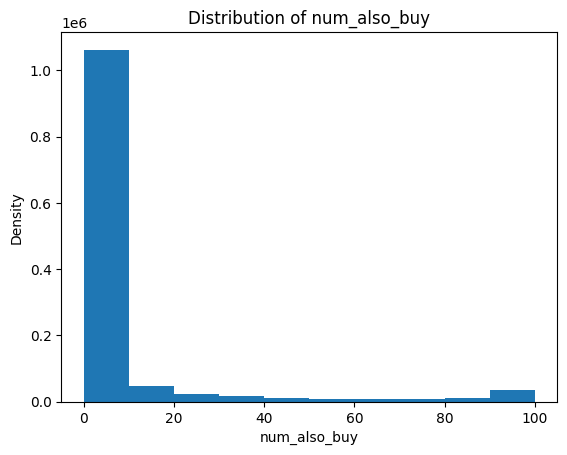

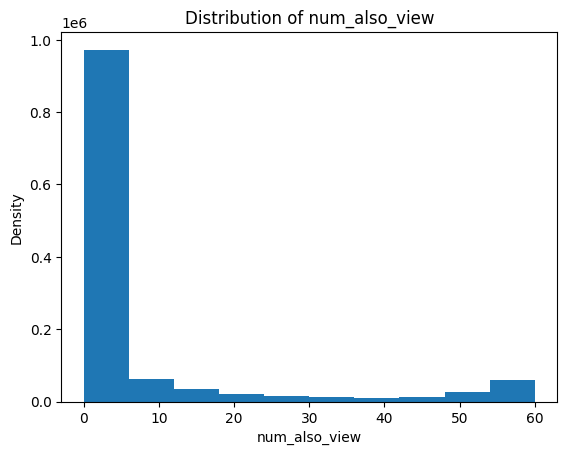

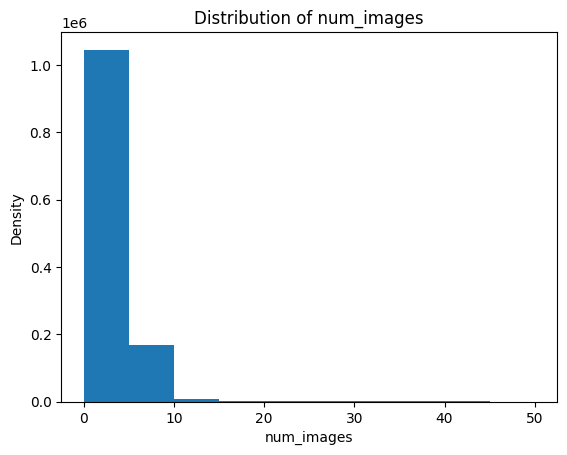

In [69]:
import matplotlib.pyplot as plt

for var in ['num_also_buy', 'num_also_view', 'num_images']:

    # Create a new figure for each plot
    plt.figure()
    # Plot the distribution (histogram)
    df[var].plot(kind='hist', title=f'Distribution of {var}')
    # Add labels
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.show()

The histograms of num_also_buy, num_also_view, and num_images clearly show highly skewed distributions where the majority of the data is concentrated at lower values, with a long tail extending towards higher values. This indicates that most data points fall into a small number of categories, while a few categories occur infrequently.

For solving this, we will apply a threshold of 1% to filter out categories with a very low frequency, in order to serve the following purposes:
1. Simplification of cateogires
2. Reduction of noise (grouping underrepresented values into a `Others` category)
3. Focus on significant patterns (by just nalyzing the most representative categories for each variable)

In [70]:
#threshold 1%
threshold = 0.01

# Get the bins
also_buy_counts = df.num_also_buy.value_counts(normalize=True)
also_view_counts = df.num_also_view.value_counts(normalize=True)
num_images_counts = df.num_images.value_counts(normalize=True)

bins_also_buy = also_buy_counts[also_buy_counts > threshold].index.tolist()
bins_also_view = also_view_counts[also_view_counts > threshold].index.tolist()
bins_images = num_images_counts[num_images_counts > threshold].index.tolist()

#Create the columns
df['also_buy_categ'] = df.num_also_buy.apply(lambda x: str(x) if x in bins_also_buy else 'Other')
df['also_view_categ'] = df.num_also_view.apply(lambda x: str(x) if x in bins_also_view else 'Other')
df['num_images_categ'] = df.num_images.apply(lambda x: str(x) if x in bins_images else 'Other')

Print the categories to see how they distribute now.

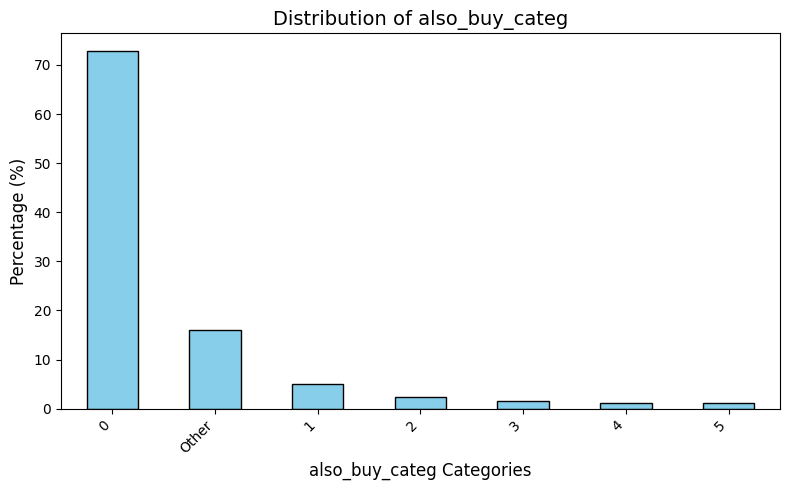

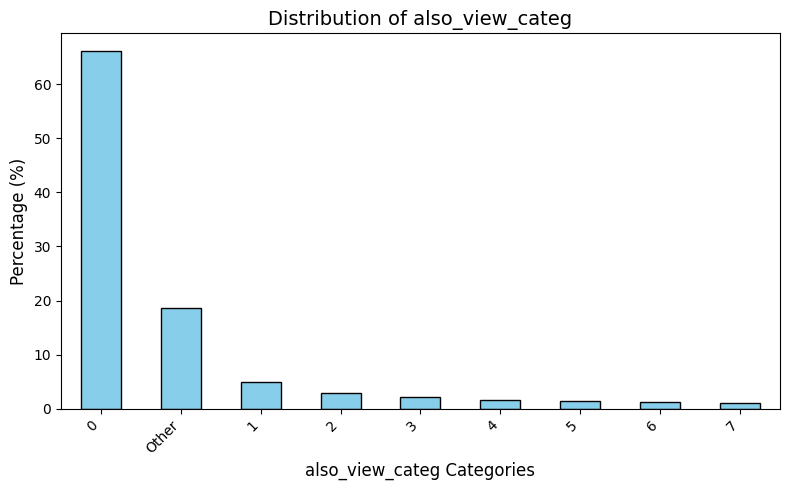

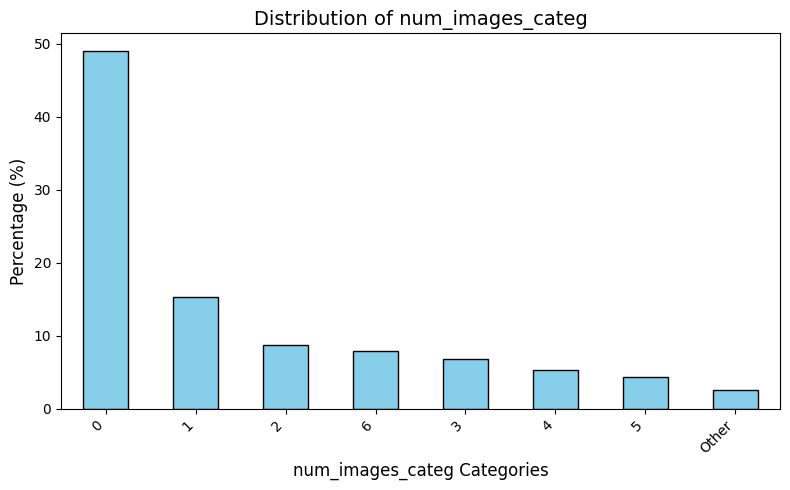

In [71]:
import matplotlib.pyplot as plt

# List of new categorical variables
categorical_vars = ['also_buy_categ', 'also_view_categ', 'num_images_categ']

# Iterate through the variables
for var in categorical_vars:
    # Get the value counts
    value_counts = df[var].value_counts(normalize=True) * 100  # Convert to percentage if desired
    # Create a bar plot
    plt.figure(figsize=(8, 5))
    value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    # Add titles and labels
    plt.title(f'Distribution of {var}', fontsize=14)
    plt.xlabel(f'{var} Categories', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    # Show the plot
    plt.tight_layout()
    plt.show()


## 2 - Feature Selection (TEXT)

### 2.1 - Cleaning text features

For the text features, we will take every possible text field in the text:
- features (concatenated)
- description (concatentaed)
- title

And apply a cleaning function, for removing non usable and noisi information:
- Remove the HTML tags (there are a lot)
- Remove non-printable characters
- Remove exessive whitespaces
- Remove special symbols to only keep the regular punctuation marks.

By doing that, we ensure ready-to-use text information to create embeddings from a DL model, that will serve as features for the model.

In [72]:
import re

def clean_text(text: str) -> str:
    """
    Cleans text by removing HTML tags, non-printable characters,
    excessive whitespace (including tabs/newlines), and special symbols
    (but keeps punctuation like . , ! ? ; : ' ").
    """

    # 1. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # 2. Remove non-printable characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # 3. Remove excessive whitespace (including tabs/newlines)
    text = re.sub(r'\s+', ' ', text).strip()

    # 4. Remove special symbols (keeping letters, digits, whitespace, punctuation)
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\;\:\'\"]+', '', text)

    return text

In [73]:
#Clean descriptions
df['description'] = df.description.apply(clean_text)
df['len_description'] = df.description.apply(len)

#Clean features
df['features'] = df.features.apply(clean_text)
df['len_features'] = df.features.apply(len)

#Clean title
df['title'] = df.title.apply(clean_text)
df['len_title'] = df.title.apply(len)

Check if there is no record with at least one text field

In [74]:
len(df.query('len_description == 0 & len_features == 0 & len_title == 0'))

0

Perfect! Every record has at least 1 text field. This will ensure later that we have at least 1 information vector to use as text feature.

### 2.2 - Text fields magnitudes `features`

For the text field, I want to add also include a "magnitude variable":

- `len_description`: length of the `description` text
- `len_title`: length of the `title`

But, for the `features`, we have two options:
- `num_features`: number of features on the feature input list. This is a bounded value up ot 20 features max
- `len_features`: length of the concatenated text

I will only use one of both, because keeping both might introduce correlation between those two inputs, which is not good for building the model.

In [75]:
df.len_features.describe()

,len_features
count,1.229098e+06
mean,2.541660e+02
std,3.543834e+02
min,0.000000e+00
25%,0.000000e+00
50%,1.480000e+02
75%,3.280000e+02
max,6.789700e+04


<Axes: >

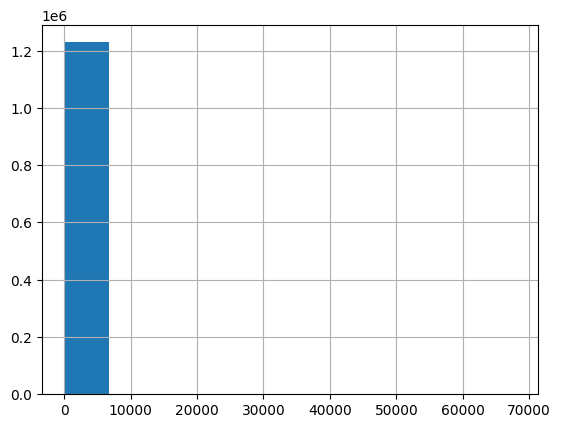

In [76]:
df.len_features.hist()

We see that is a very very skewed distribution.

<Axes: >

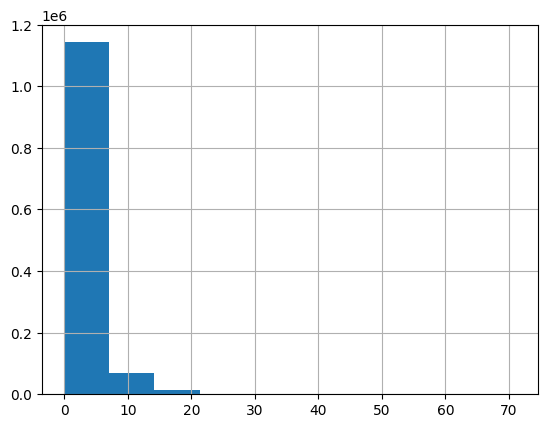

In [77]:
df.num_features.hist()

In [78]:
df.num_features.value_counts(normalize=True).head(10)

,proportion
num_features,
5,0.357655
0,0.291641
3,0.087648
4,0.087182
1,0.050422
2,0.026252
6,0.018552
10,0.011521
7,0.010490


The `num_features` is also a skewed distribution but it has only integers values (and much less of them) and more distributed among the samples, so we will keep it as the magnitude feature for `features`

## 3 - Save the DF

If needed, we can now save the processed dataset, although we will build a **separate module** for data cleaning and preparation.

In [79]:
interest_cols = [
    'title',
    'len_title',
    'description',
    'len_description',
    'features',
    'num_features',
    'main_cat',
    'also_buy_categ',
    'also_view_categ',
    'num_images_categ'
]

final_df = df[interest_cols]

In [55]:
final_df.to_csv('df_limpio.csv', index=False)